In [16]:
import cv2
import os
import math
import six
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

tf.random.set_seed(1)

ORIG_SEGMENTATION_DIR = "./data/VOCdevkit/VOC2012/SegmentationClass"

LIST_DIR = './data/VOCdevkit/VOC2012/ImageSets/Segmentation'
OUTPUT_DIR = "./data/VOCdevkit/tfrecord"

IMAGE_DIR = './data/VOCdevkit/VOC2012/JPEGImages/'
CONV_SEGMENTATION_DIR = "./data/VOCdevkit/VOC2012/SegmentationClassRaw/"
IMAGE_FORMAT = 'jpg'
SEGMENTATION_FORMAT = 'png'

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
OUTPUT_CHANNELS = 21

In [17]:
def _save_annotation(annotation, filename):
    """Saves the annotation as png file.
    Args:
    annotation: Segmentation annotation.
    filename: Output filename.
    """
    pil_image = Image.fromarray(annotation.astype(dtype=np.uint8))
    with tf.io.gfile.GFile(filename, mode='w') as f:
        pil_image.save(f, 'PNG')
        
def _remove_colormap(filename):
    """Removes the color map from the annotation.
    Args:
    filename: Ground truth annotation filename.
    Returns:
    Annotation without color map.
    """
    image = Image.open(filename)
    image = np.array(image)
    image[image > 20] = 0
    return image
    
def remove_color_map_process():
    # Create the output directory if not exists.
    if not tf.io.gfile.isdir(CONV_SEGMENTATION_DIR):
        tf.io.gfile.mkdir(CONV_SEGMENTATION_DIR)

    annotations = tf.io.gfile.glob(os.path.join(ORIG_SEGMENTATION_DIR, '*.' + SEGMENTATION_FORMAT))
    for annotation in annotations:
        raw_annotation = _remove_colormap(annotation)
        filename = os.path.basename(annotation)[:-4]
        _save_annotation(raw_annotation,
                         os.path.join(
                             CONV_SEGMENTATION_DIR,
                             filename + '.' + SEGMENTATION_FORMAT))

remove_color_map_process()

In [18]:
NUM_SHARDS = 4

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

class ImageReader(object):
    def __init__(self, image_format='png', channels=3): #adding b before 'png' to explicitly say that it should be a byte string
        self._image_format = image_format
        self.channels = channels
        
    def read_image_dims(self, image_data):
        """Reads the image dimensions.
        Args:
          image_data: string of image data.
        Returns:
          image_height and image_width.
        """
        image = self.decode_image(image_data)
        return image.shape[:2]

    def decode_image(self, image_data):
        """Decodes the image data string.
        Args:
          image_data: string of image data.
        Returns:
          Decoded image data.
        Raises:
          ValueError: Value of image channels not supported.
        """
        if self._image_format in ('jpeg', 'jpg'):
            image = tf.image.decode_jpeg(image_data, channels=self.channels)
        elif self._image_format == 'png': #adding b to explicitly say that it should be a byte string
            image = tf.image.decode_png(image_data, channels=self.channels)
            
        if len(image.shape) != 3 or image.shape[2] not in (1, 3):
            raise ValueError('The image channels not supported.')

        return image

In [19]:
def img_seg_to_example(filename, image_data, seg_data, height, width):
    feature = {
        'image/filename': _bytes_feature(filename.encode('utf8')),
        'image/height': _int64_feature(height),
        'image/width': _int64_feature(width),
        'image/encoded': _bytes_feature(image_data),
        'image/format': _bytes_feature('jpeg'.encode('utf8')),
        'label/encoded': _bytes_feature(seg_data),
        'label/format': _bytes_feature('png'.encode('utf8'))
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))


def convert_dataset(dataset_split):
    dataset = os.path.basename(dataset_split)[:-4]
    
    filenames = [x.strip('\n') for x in open(dataset_split, 'r')]
    num_images = len(filenames)
    
    print(f"Processing {dataset}: {num_images} Images")
    num_per_shard = int(math.ceil(num_images / NUM_SHARDS))
    
    image_reader = ImageReader('jpeg', channels=3)
    label_reader = ImageReader('png', channels=1)
    
    for shard_id in range(NUM_SHARDS):
        output_filename = os.path.join(OUTPUT_DIR, '%s-%05d-of-%05d.tfrecord' % (dataset, shard_id, NUM_SHARDS))
        
        with tf.io.TFRecordWriter(output_filename) as writer:
            start_idx = shard_id * num_per_shard
            end_idx = min((shard_id + 1) * num_per_shard, num_images)
            
            for i in range(start_idx, end_idx):
                # READ IMAGE
                image_filename = os.path.join(IMAGE_DIR, filenames[i] + '.' + IMAGE_FORMAT)
                image_data = tf.io.gfile.GFile(image_filename, 'rb').read()

                # READ SEGMENTATION
                seg_filename = os.path.join(CONV_SEGMENTATION_DIR, filenames[i] + '.' + SEGMENTATION_FORMAT)
                seg_data = tf.io.gfile.GFile(seg_filename, mode='rb').read()
                
                height, width = image_reader.read_image_dims(image_data)
                seg_height, seg_width = label_reader.read_image_dims(seg_data)
                if height != seg_height or width != seg_width:
                    print("-----")
                    print(height, seg_height)
                    print(width, seg_width)
                    print("----")
                else:
                    # CREATE TFREzCORD EXAMPLE
                    example = img_seg_to_example(filenames[i], image_data, seg_data, height, width)

                    # WRITE TO DISK
                    writer.write(example.SerializeToString())
                
if not tf.io.gfile.isdir(OUTPUT_DIR):
    tf.io.gfile.mkdir(OUTPUT_DIR)

dataset_splits = tf.io.gfile.glob(os.path.join(LIST_DIR, "*.txt"))
for dataset_split in dataset_splits:
    print(dataset_split)
    convert_dataset(dataset_split)

./data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt
Processing train: 1464 Images
./data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt
Processing val: 1449 Images


In [20]:
def parse_dataset(example_proto):
    features = {
        'image/filename':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/format':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/height':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/width':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'label/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'label/format':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
    }
    
    parsed_feature = tf.io.parse_single_example(example_proto, features)
    
    image = tf.cast(tf.image.decode_jpeg(parsed_feature['image/encoded'], channels=3), dtype=tf.float32)
    label = tf.cast(tf.image.decode_png(parsed_feature['label/encoded'], channels=1), dtype=tf.uint8)
   
    return image, label

train_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/train-*.tfrecord")
valid_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/val-*.tfrecord")

train = (tf.data
    .TFRecordDataset(train_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE))

valid = (tf.data
    .TFRecordDataset(valid_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE))

for i in train.take(9):
    print(np.unique(i[1]))

[0 5]
[ 0 19]
[ 0 13]
[ 0 15]
[0 3]
[ 0 13]
[ 0 19]
[0 7]
[ 0 14]


In [183]:
arr = Image.open("./data/benchmark_RELEASE/dataset/pngs/2008_000084.png")
import PIL

PIL.Image.open(encoded_label_io)

array([ 0,  2, 15], dtype=uint8)

In [127]:
def conv_block(layer_size, input_data, filters, kernel_size = 3, dilation_rate=1, padding = 'same', pool = False, name = ''):
    if dilation_rate == 1:
        conv_type = 'conv'
    else:
        conv_type = 'dilated_conv'
    
    for i in range(1, layer_size + 1):
        input_data = (keras.layers.Conv2D(
                filters=filters, 
                kernel_size=kernel_size, 
                dilation_rate=dilation_rate,
                padding=padding,
                name=f'block_{conv_type}_{name}_{i}', 
                use_bias=True))(input_data)
        input_data = keras.layers.Activation('relu', name=f'relu_{name}_{i}')(input_data)
        
    if pool:
        input_data = keras.layers.MaxPool2D(2, name=f'max_pool_{name}')(input_data)
    
    return input_data
  
def bilinear_upsample(sample):
    image_size = sample[1]
    upsampled = tf.image.resize(sample[0], size=(image_size[0], image_size[1]), method='bilinear')
    return upsampled
    
def build_network(input_shape, nclasses, use_ctx = False):
    inputs = keras.layers.Input(input_shape)
    x = conv_block(layer_size=2, input_data=inputs, kernel_size=3, filters=N_CLASSES, pool=True, name=1)
    x = conv_block(layer_size=2, input_data=x, kernel_size=3, filters=N_CLASSES * 2, pool=True, name=2)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 4, pool=True, name=3)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 8, pool=False, name=4)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 8, dilation_rate=2, pool=False, name=5)
    
    x = conv_block(layer_size=1, input_data=x, kernel_size=7, filters=4096, dilation_rate=4, name='_FCN1')
    x = keras.layers.Dropout(0.5)(x)
    x = conv_block(layer_size=1, input_data=x, kernel_size=7, filters=4096, name='_FCN2')
    x = keras.layers.Dropout(0.5)(x)
    
    if use_ctx:
        x = conv_block(layer_size=2, input_data=x, filters=N_CLASSES * 2, kernel_size=3, name='_ctx1')
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 4, kernel_size=3, name='_ctx2', dilation_rate=2)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 8, kernel_size=3, name='_ctx3', dilation_rate=4)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 16, kernel_size=3, name='_ctx4', dilation_rate=8)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 32, kernel_size=3, name='_ctx5', dilation_rate=16)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 32, kernel_size=3, name='_ctx6')
        x = keras.layers.Conv2D(filters=nclasses, kernel_size=1, padding='same', name='ctx_output')(x)
    
    x = keras.layers.Lambda(bilinear_upsample, name='bilinear_upsample')([x, input_shape])
    x = keras.layers.Softmax()(x)
    
    return keras.Model(inputs, x)

In [119]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

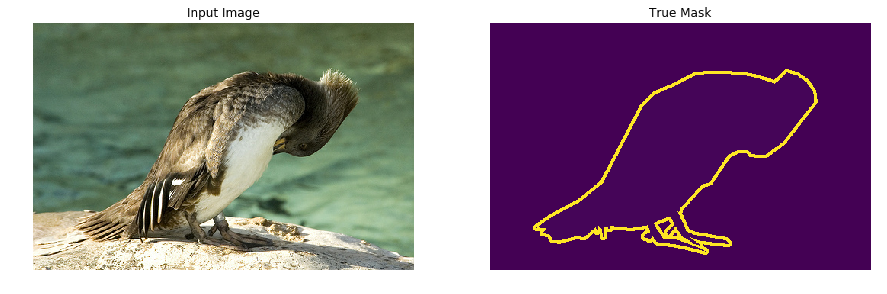

In [120]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [121]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [122]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [123]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1800//BATCH_SIZE//VAL_SUBSPLITS

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_network((IMG_DIM, IMG_DIM, 3), OUTPUT_CHANNELS, use_ctx=True)
    model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=(1800 // BATCH_SIZE),
                            validation_steps=VALIDATION_STEPS,
                            validation_data=valid_dataset)

W0529 12:32:25.688148 4617256384 cross_device_ops.py:1209] There is non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.


Train for 56 steps, validate for 11 steps
Epoch 1/50
 1/56 [..............................] - ETA: 4:27

InvalidArgumentError:   Expected image (JPEG, PNG, or GIF), got empty file
	 [[{{node DecodePng_1}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]]
	 [[IteratorGetNextAsOptional]] [Op:__inference_distributed_function_163923]

Function call stack:
distributed_function -> distributed_function
